# Parámetros de un nucleo gaussiano

$$\max \left(\sum_{i=1}^n b_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n y_i b_i k(x_i, x_j) y_j b_j\right)$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn  import datasets

In [2]:
session = tf.Session()

In [3]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])

class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

In [4]:
batch_size = 150

x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

prediction_grid = tf.placeholder(shape=[None,2], dtype=tf.float32)

b = tf.Variable(tf.random_normal(shape=[1, batch_size]))

In [5]:
gammas = [1.0, 10.0, 25.0, 100.0] #valor de kernel gaussiano, entre mas negativo mas estricta la clasificacion

In [16]:
#Grafos para definir kernel
gamma = tf.constant(-50.0) #valor de kernel gaussiano, entre mas negativo mas estricta la clasificacion

dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_distance = tf.add(tf.sub(dist, tf.mul(2.0, tf.matmul(x_data, tf.transpose(x_data)))), 
                     tf.transpose(dist))
my_kernel = tf.exp(tf.mul(gamma, tf.abs(sq_distance)))

first_sum = tf.reduce_sum(b)
b_vect_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_sum = tf.reduce_sum(tf.mul(my_kernel, tf.mul(b_vect_cross, y_target_cross)))
loss = tf.neg(tf.sub(first_sum, second_sum))

rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid),1), [-1,1])

pred_sq_dist = tf.add(tf.sub(rA, tf.mul(2.0, tf.matmul(x_data, tf.transpose(prediction_grid)))), 
                      tf.transpose(rB))
pred_kernel = tf.exp(tf.mul(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.mul(tf.transpose(y_target), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

my_optim = tf.train.GradientDescentOptimizer(0.01)
train_step = my_optim.minimize(loss)
init = tf.initialize_all_variables()
session.run(init)

loss_vect = []
batch_acc = []
for i in range(400):
    rand_idx = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_idx]
    rand_y = np.transpose([y_vals[rand_idx]])
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vect.append(temp_loss)
    
    
    acc_temp = session.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y, prediction_grid:rand_x})
    batch_acc.append(acc_temp)
    
    if(i+1)%50==0:
        print("Paso #"+str(i+1)+ ", Pérdida = "+str(temp_loss)+", Precisión = "+str(acc_temp))
        
        
x_min, x_max = x_vals[:,0].min()-1, x_vals[:,0].max()+1
y_min, y_max = x_vals[:,1].min()-1, x_vals[:,1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]

[grid_predictions] = session.run(prediction, feed_dict={x_data: x_vals,
                                                   y_target: np.transpose([y_vals]),
                                                   prediction_grid: grid_points})

grid_predictions = grid_predictions.reshape(xx.shape)

Paso #50, Pérdida = 8.31686, Precisión = 0.746667
Paso #100, Pérdida = -4.81543, Precisión = 0.966667
Paso #150, Pérdida = -7.41958, Precisión = 0.993333
Paso #200, Pérdida = -7.36023, Precisión = 1.0
Paso #250, Pérdida = -7.59031, Precisión = 1.0
Paso #300, Pérdida = -7.84214, Precisión = 1.0
Paso #350, Pérdida = -7.78848, Precisión = 1.0
Paso #400, Pérdida = -7.88559, Precisión = 1.0


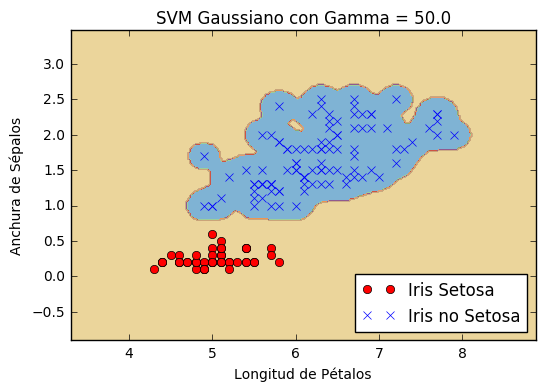

In [17]:
plt.contourf(xx, yy, grid_predictions, cmap = plt.cm.Paired, alpha = 0.7)
plt.plot(class1_x, class1_y, 'ro', label = "Iris Setosa")
plt.plot(class2_x, class2_y, 'bx', label = "Iris no Setosa")
plt.title("SVM Gaussiano con Gamma = "+str(-session.run(gamma)))
plt.xlabel("Longitud de Pétalos")
plt.ylabel("Anchura de Sépalos")
plt.legend(loc="lower right")
plt.show()